### Question 1

**Predict the number of order days Do it for all the users that appear in the file 'august_with_missing_order_days.parquet'. Note : Your prediction is the remaining orders left for the month. If a user places 3 orders on the 10th, 20th, and 30th. We would want our predictions before the 10th to be 3, before the 20th to be 2, etc.**

In [28]:
import pandas as pd


In [366]:
df = pd.read_parquet('data_files_challenge/historical_orders.parquet')
df_august = pd.read_parquet('data_files_challenge/august_with_missing_order_days.parquet')
df_august_total_sales = pd.read_parquet('data_files_challenge/august_total_sales.parquet')

In the case of users with missing data, we will fill in the date with the first day of August and the trnsaction amount with the median value.

In [297]:
df_august = df_august.fillna({'order_date':'2022-08-01', 'transaction_amount': df_august.transaction_amount.median()})

In [363]:
print(f'There are {df_august.account_id.nunique()} unique users in the August dataset and {df.account_id.nunique()} in the train dataset')

There are 32944 unique users in the August dataset and 47899 in the train dataset


In [364]:
data = pd.concat([df, df_august], axis=0)

In [365]:
data

,account_id,order_date,transaction_amount
0,BR_09607801000194,2021-08-28,11011.2
1,BR_09607801000194,2021-08-28,13764.0
2,BR_09607801000194,2021-08-28,11011.2
3,BR_09607801000194,2021-08-28,11011.2
4,BR_09607801000194,2021-08-28,13764.0
...,...,...,...
317730,BR_30398656000175,2022-08-01,84.0
317731,BR_01248390377,2022-08-01,84.0
317732,BR_03803067863,2022-08-01,84.0
317733,BR_49558358487,2022-08-01,84.0


Let's do an aggregation on the dataset, calculating the number of orders and transaction amount per day.

In [378]:
data['order_date'] = pd.to_datetime(data['order_date'], format='%Y-%m-%d', errors='coerce')

user_data = data.groupby(['account_id', 'order_date']).agg(
    order_count=('transaction_amount', 'size'),
    amount=('transaction_amount', 'sum')
).reset_index()


In [379]:
user_data['year_month'] = user_data['order_date'].dt.strftime('%Y-%m')
user_data['order_date_true'] = 1


Age is the number of time periods since their first purchase.

In [380]:
user_data['first_order_date'] = user_data.groupby('account_id')['order_date'].transform('min')
user_data['age'] = (user_data['order_date'] - user_data['first_order_date']).dt.days

Recency indicates the time period when a customer made their most recent purchase. If a customer has only made 1 purchase, recency is 0.

In [381]:

user_data['previous_order_date'] = user_data.groupby('account_id')['order_date'].shift(1)
user_data['recency'] = (user_data['order_date'] - user_data['previous_order_date']).dt.days.fillna(0)

Now, let's create cumulative columns

- **Orders_remaining**: Difference between the monthly total of order_count and the accumulated total up to the current point (c_orders).
Indicates how many orders are still to be processed in the month.

- **Orders_days_remaining**: THe model label. Difference between the monthly total of order days and the accumulated total up to the current point (c_orders_days).
Indicates how many days are still to be counted.

- **Amount_remaining**: Difference between the monthly total of amount and the accumulated total up to the current point (c_amount).
Indicates how much value is still to be transacted in the month.

In [ ]:
user_data[['c_orders', 'c_orders_days', 'c_amount']] = (
    user_data.groupby(['account_id', 'year_month'])[['order_count', 'order_date_true', 'amount']].cumsum()
)

user_data['orders_remaining'] = (
    user_data.groupby(['account_id', 'year_month'])['order_count']
    .transform('sum') - user_data['c_orders']
)

user_data['orders_days_remaining'] = (
    user_data.groupby(['account_id', 'year_month'])['order_date_true']
    .transform('sum') - user_data['c_orders_days']
)

user_data['amount_remaining'] = (
    user_data.groupby(['account_id', 'year_month'])['amount']
    .transform('sum') - user_data['c_amount']
)

As a feature, the number of days remaining in the month and the month of the order were also created.

In [383]:
last_day_of_month = user_data['order_date'].dt.to_period('M').dt.end_time
user_data['remaining_days'] = (last_day_of_month - user_data['order_date']).dt.days
user_data['month'] = user_data['order_date'].dt.month

In [384]:
user_data

,account_id,order_date,order_count,amount,year_month,order_date_true,first_order_date,age,previous_order_date,recency,c_orders,c_orders_days,c_amount,orders_remaining,orders_days_remaining,amount_remaining,remaining_days,month
0,BR_00000343803,2021-01-07,2,252.88,2021-01,1,2021-01-07,0,NaT,0.0,2,1,252.88,5,3,562.04,24,1
1,BR_00000343803,2021-01-14,1,49.52,2021-01,1,2021-01-07,7,2021-01-07,7.0,3,2,302.40,4,2,512.52,17,1
2,BR_00000343803,2021-01-21,2,173.96,2021-01,1,2021-01-07,14,2021-01-14,7.0,5,3,476.36,2,1,338.56,10,1
3,BR_00000343803,2021-01-30,2,338.56,2021-01,1,2021-01-07,23,2021-01-21,9.0,7,4,814.92,0,0,0.00,1,1
4,BR_00000343803,2021-02-11,1,111.20,2021-02,1,2021-01-07,35,2021-01-30,12.0,1,1,111.20,3,1,373.56,17,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485744,BR_99980878134,2021-05-29,4,160.02,2021-05,1,2021-05-18,11,2021-05-25,4.0,13,3,408.25,0,0,0.00,2,5
1485745,BR_99980878134,2021-06-07,2,139.30,2021-06,1,2021-05-18,20,2021-05-29,9.0,2,1,139.30,8,3,234.44,23,6
1485746,BR_99980878134,2021-06-10,2,36.96,2021-06,1,2021-05-18,23,2021-06-07,3.0,4,2,176.26,6,2,197.48,20,6
1485747,BR_99980878134,2021-06-12,1,76.36,2021-06,1,2021-05-18,25,2021-06-10,2.0,5,3,252.62,5,1,121.12,18,6


With the features created, we can now create the training data for a regression model.

In [385]:
train_data = user_data[user_data['order_date'] < '2022-08-01']

features = ['account_id', 'c_amount', 'amount', 'amount_remaining', 'remaining_days', 'c_orders', 'c_orders_days', 'month', 'recency', 'age']
X_train = train_data[features]
y_train = train_data['orders_days_remaining']

The data we will use for prediction is from the month of August 2022. We must also filter the user_data dataset to include only records with the most recent order date (order_date) for each account_id

In [392]:
august_user_data = user_data[user_data.order_date>='2022-08-01']
august_user_data = august_user_data.loc[august_user_data.groupby('account_id')['order_date'].idxmax()]

X_pred = august_user_data[features]

We will use **df_august_total_sales** to adjust the total sales for the month to the forecasted value.

In [395]:
X_pred = X_pred.merge(df_august_total_sales, on='account_id', how='left').drop(columns=['amount']).rename(columns = {'total_transaction_amount_august':'amount'})
X_pred['amount_remaining'] = X_pred['amount'] - X_pred['c_amount']

The code above defines a class Train_model that facilitates training a CatBoostRegressor model with hyperparameter optimization using Bayesian Optimization.
Key Components in the Code:

- **CatBoostRegressor**: The model being trained. It handles categorical features natively and provides powerful gradient boosting.
- **Bayesian Optimization**: Used to optimize the hyperparameters such as depth, learning_rate, etc.
- **Cross-Validation**: Used for model evaluation, ensuring that the model generalizes well to unseen data.

In [367]:
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization

class Train_model:
    def __init__(self, X: pd.DataFrame, y:pd.Series, default_params: dict):
        self.X = X
        self.y = y
        self.default_params = default_params

    def _cat_evaluate(
        self, depth, learning_rate, colsample_bylevel, min_data_in_leaf
    ):
        params = {
            "depth": int(depth),
            "learning_rate": learning_rate,
            "colsample_bylevel": colsample_bylevel,
            "min_data_in_leaf": int(min_data_in_leaf),
        }
        model = CatBoostRegressor(
            **params,
            **self.default_params
        )

        cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)
        cv_score = cross_val_score(model, self.X, self.y.ravel(), cv=cv, scoring="neg_root_mean_squared_error")
        return cv_score.mean()


    def fit(self, model_name="catboost", n_iter=20):

        if model_name == "catboost":
            print("Finding best parameters... {}".format(pd.Timestamp.now()))
            xgb_bo = BayesianOptimization(
                self._cat_evaluate,
                {
                    "depth": (1, 15),
                    "learning_rate": (0.001, 0.3),
                    "colsample_bylevel": (0.05, 1.0),
                    "min_data_in_leaf": (1, 100),
                },
            )
            xgb_bo.maximize(init_points=5, n_iter=n_iter)
            best_params: dict = xgb_bo.max["params"]  # type: ignore
            best_params["depth"] = int(best_params["depth"])
            best_params["min_data_in_leaf"] = int(best_params["min_data_in_leaf"])

            print("Fitting model... {}".format(pd.Timestamp.now()))
            new_cat_classifier = CatBoostRegressor(
                **best_params,
                **self.default_params
            )
            # xgb_classifier_c = CalibratedClassifierCV(new_xgb_classifier,
            #                                          method='sigmoid', cv=3)
            # xgb_classifier_c.fit(self.X, self.y)
            return new_cat_classifier.fit(self.X, self.y)

In [368]:

cat_features = ['account_id']
default_cat_params = {
            "task_type": "CPU",
            "cat_features": cat_features,
            "silent": True,
            "iterations":30,
        }

catboost = Train_model(X_train, y_train, default_cat_params).fit(model_name='catboost', n_iter=25)

Finding best parameters... 2024-12-07 01:57:14.769344
|   iter    |  target   | colsam... |   depth   | learni... | min_da... |
-------------------------------------------------------------------------
| 1         | -1.203    | 0.1154    | 3.103     | 0.2757    | 38.89     |
| 2         | -0.8553   | 0.9525    | 12.57     | 0.1732    | 59.27     |
| 3         | -1.002    | 0.3884    | 5.481     | 0.1108    | 27.42     |
| 4         | -0.9054   | 0.424     | 6.582     | 0.231     | 9.798     |
| 5         | -1.837    | 0.0952    | 7.044     | 0.04386   | 44.8      |
| 6         | -0.8566   | 1.0       | 13.98     | 0.1567    | 63.28     |
| 7         | -0.8834   | 1.0       | 6.058     | 0.3       | 64.38     |
| 8         | -2.179    | 0.05      | 10.27     | 0.001     | 73.7      |
| 9         | -2.141    | 1.0       | 5.106     | 0.001     | 58.34     |
| 10        | -0.8447   | 0.9699    | 10.98     | 0.2931    | 62.31     |
| 11        | -1.531    | 0.1783    | 6.799     | 0.04466 

In [398]:
X_pred['prediction'] =  catboost.predict(X_pred)
X_pred[['account_id', 'prediction']].to_csv('order_days_prediction.csv', index=False)

As specified, we create the dataset containing account_id and the prediction column

In [400]:
pd.read_csv('order_days_prediction.csv')

,account_id,prediction
0,BR_00000343803,1.595746
1,BR_00001415930,2.333842
2,BR_00001760106,3.907333
3,BR_00002485176,1.190776
4,BR_00002536340,2.115390
...,...,...
32939,BR_99904403791,2.194116
32940,BR_99910241587,2.414070
32941,BR_99936259300,2.200871
32942,BR_99946866587,1.281519


### Questão 2

**2a. Can you describe the distribution of the number of order days of a user (or a group of users) via a known probability distribution? Propose a formula/density function and explain your solution.**

Well, the most natural choice for this problem is the Poisson distribution! This distribution works under the assumption that the number of orders on any given day is independent and occurs at a certain average rate—denoted by $𝜆$, which represents the expected number of orders on any single day. This formula calculates the probability of having exactly 
𝑘
k events (order days) in that period.

$$f(k,\lambda) = \frac{e^{-k}\lambda^{k}}{k!}$$

In [421]:
import pandas as pd
import seaborn as sns
import math
from scipy.stats import poisson
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np

To prove that the poisson distribution is adequate, we will use the historical orders dataset used in question 1.

In [403]:
df = pd.read_parquet('data_files_challenge/historical_orders.parquet')
df

,account_id,order_date,transaction_amount
0,BR_09607801000194,2021-08-28,11011.2
1,BR_09607801000194,2021-08-28,13764.0
2,BR_09607801000194,2021-08-28,11011.2
3,BR_09607801000194,2021-08-28,11011.2
4,BR_09607801000194,2021-08-28,13764.0
...,...,...,...
9397109,BR_07543270000198,2022-04-07,463.0
9397110,BR_11366636000178,2022-04-07,378.0
9397111,BR_80376890000170,2022-04-07,448.2
9397112,BR_09010853403,2022-04-07,407.4


Here, we process the order data by converting dates, grouping by users and months, counting the unique order days, and filtering to focus on users with a significant number of order months (more than 10).

In [407]:

df_day_orders_n = (df.assign(year_month=pd.to_datetime(df['order_date']).dt.to_period('M').astype(str))
                    .groupby(['account_id', 'year_month'])['order_date']
                    .nunique()
                    .reset_index(name='num_days_orders')
                    .loc[lambda x: x['account_id'].isin(
                        x['account_id'].value_counts()[lambda y: y > 10].index)]
)
df_day_orders_n

Let's select a sample of 1000 users. Now, For each user, we need to ensure that there is a continuous time series of months from the user's first order month to July 2022, with missing months filled with zero order days.

In [413]:

sample_users = random.choices(df_day_orders_n.account_id.unique(), k=1000)
list_dfs = []
for user in sample_users:  # Seleção de 100 usuários para amostra
    df_user_1 = df_day_orders_n[df_day_orders_n['account_id'] == user]
    all_months = pd.date_range(start=df_user_1['year_month'].min(), end='2022-07', freq='M').to_period('M').astype(str)
    all_months_df = pd.DataFrame(all_months, columns=['year_month'])
    # Gerando um DataFrame com todas as combinações de meses e o número de dias com pedidos
    result_df = pd.merge(all_months_df, df_user_1[['year_month', 'num_days_orders']], on='year_month', how='left').fillna(0)
    list_dfs.append(result_df)


In [414]:
df_final = pd.concat(list_dfs)
df_final

,year_month,num_days_orders
0,2021-03,2.0
1,2021-04,5.0
2,2021-05,4.0
3,2021-06,3.0
4,2021-07,2.0
...,...,...
13,2022-02,6.0
14,2022-03,6.0
15,2022-04,5.0
16,2022-05,9.0


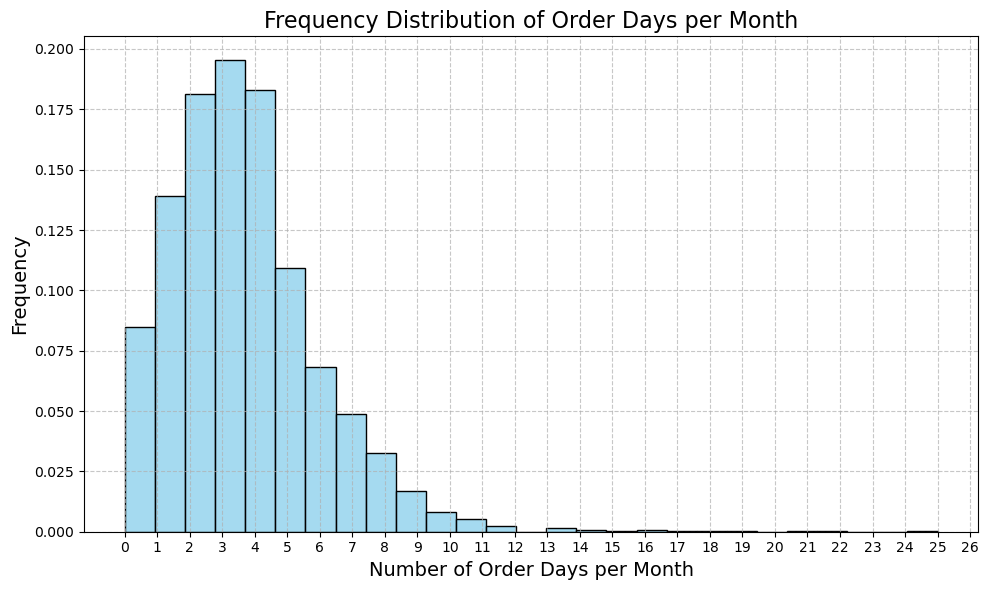

In [419]:

# Plot the frequency distribution (histogram)
plt.figure(figsize=(10, 6))
n_bins = 27
sns.histplot(df_final.num_days_orders, bins=n_bins, kde=False, color='skyblue', stat="density")
# Configuring the plot
plt.title('Frequency Distribution of Order Days per Month', fontsize=16)
plt.xlabel('Number of Order Days per Month', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(0, n_bins))
plt.tight_layout()
plt.show()

**2b) How could you estimate the parameter/s of this function?**

Using Maximum Likelihood Estimation (MLE) to estimate the parameters. For a Poisson distribution, the goal is to estimate the parameter $\lambda% (order days per month), based on observed data.

The likelihood function for the **Poisson distribution** is:

$$
L(\lambda) = \prod_{i=1}^{n} \frac{\lambda^{k_i} e^{-\lambda}}{k_i!}
$$

Where:
- $k_i$ is the number of order days (or events) observed for the \(i\)-th observation.
- $n$ is the total number of observations (e.g., the number of users or months).
- $\lambda$ is the parameter to be estimated.

To simplify the maximization process, we typically take the **log-likelihood function**:

$$
\log L(\lambda) = \sum_{i=1}^{n} \left( k_i \log \lambda - \lambda - \log(k_i!) \right)
$$

Taking the derivative of this log-likelihood function with respect to $\lambda$ and setting it equal to zero, we get the MLE for $\lambda$:

$$
\hat{\lambda} = \frac{1}{n} \sum_{i=1}^{n} k_i
$$

In other words, the MLE for $\lambda$ is simply the **sample mean** of the observed number of order days.

In [422]:
lambda_value = np.mean(df_final.num_days_orders)
print(f"Estimated lambda (MLE) is: {lambda_value}")

Estimated lambda (MLE) is: 3.4981344354514667


We can see from the figure below that there is a good fit between the observed data and the Poisson distribution, with the lambda value estimated using MLE.

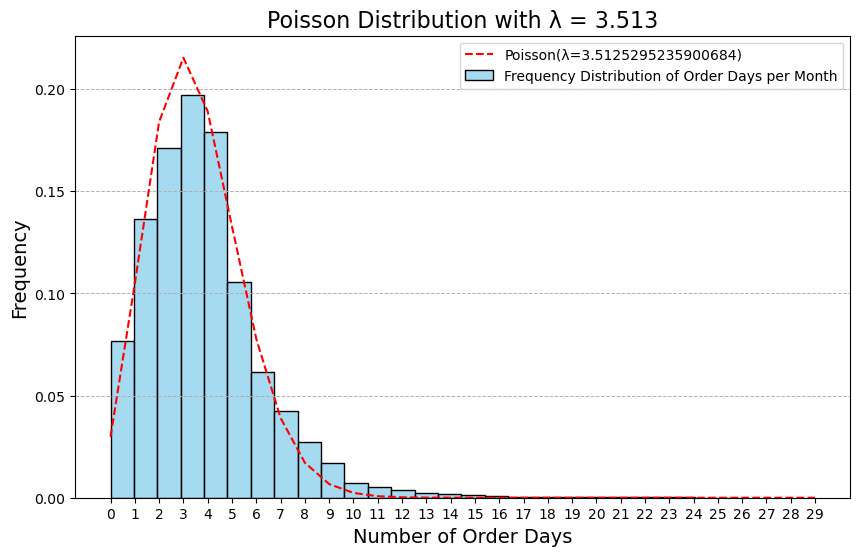

In [485]:
x = np.arange(0, 30)
y = y = poisson.pmf(x, lambda_value) 

# Plotar a distribuição
plt.figure(figsize=(10, 6))
sns.histplot(df_final.num_days_orders, bins=27, kde=False, color='skyblue', stat="density", label='Frequency Distribution of Order Days per Month')
plt.plot(x, y, 'r--', label=f'Poisson(λ={lambda_value})')

plt.title(f"Poisson Distribution with λ = {round(lambda_value,3)}", fontsize=16)
plt.xlabel("Number of Order Days", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(x)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.legend()
plt.show()

**2c) Given the formula/density function, propose a simple way to calculate the probability of having more than 4 days of orders.**

To calculate the probability of having more than 4 days of orders, $P(k>4)$, we use the complement:
$$P(k>4)=1−P(k≤4)$$
This leads to:
$$P(k > 4) = 1 - \sum_{k=0}^{4} \frac{e^{-\lambda} \lambda^k}{k!}$$

In [423]:
k_max = 4
p_k_leq_4 = sum((math.exp(-lambda_value) * lambda_value**k / math.factorial(k)) for k in range(k_max + 1))

# Calculate P(k > 4)
p_k_greater_4 = 1 - p_k_leq_4
print(f"P(k > 4): {p_k_greater_4:.4f}")

P(k > 4): 0.2742


Another implementation with the scipy library gave the same result.

In [489]:
p_k_greater_4 = 1 - poisson.cdf(4, lambda_value)
print(f"P(k > 4): {p_k_greater_4:.4f}")

P(k > 4): 0.2769


**2d. We want to estimate the time between days of orders. Propose a formula that can estimate this time.**

If the number of orders per day follows a **Poisson distribution**, the time between days of orders can be modeled by an **Exponential distribution**. This relationship arises because the Poisson process describes the count of events in a given time interval, and the time between consecutive events in such a process follows the exponential distribution:

$$f(t; \lambda) = \lambda e^{-\lambda t}, \quad t \geq 0$$

Where:
- $t$ is the time between consecutive events.
- $\lambda$ is the rate parameter (average number of orders per unit time).

The **expected time between orders** is given by:

$$\mathbb{E}[T] = \frac{1}{\lambda}$$

In [425]:
expected_time = 1 / lambda_value
print(f"Expected time between orders: {expected_time*30:.2f} days")

Expected time between orders: 8.58 days


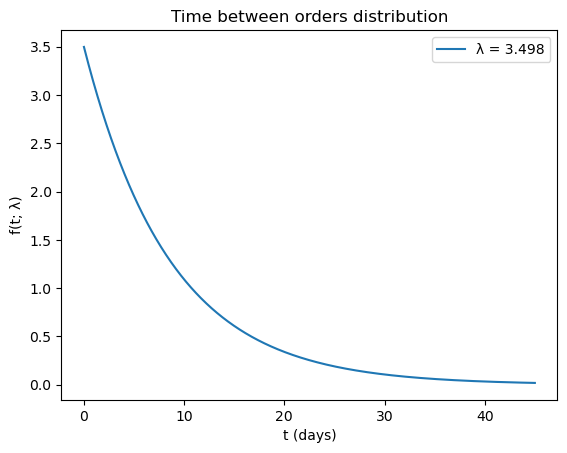

In [436]:
t_values = np.linspace(0, 1.5, 1000)
time_between_orders_dist = lambda_value * np.exp(-lambda_value * t_values)

# Plotando o gráfico
plt.plot(t_values*30, time_between_orders_dist, label=f'λ = {round(lambda_value,3)}')
plt.title('Time between orders distribution')
plt.xlabel('t (days)')
plt.ylabel('f(t; λ)')
plt.legend()
plt.show()

For  example, the  probability to have a time between orders lesser than 1 month (30 days) is


$$ F(1; \lambda) = \int_0^{1} f(t; \lambda) \, dt = \int_0^{1} \lambda e^{-\lambda t}, dt $$

We can now compute the integral:

$$
F(1; \lambda) = \left[ -e^{-\lambda t} \right]_0^{1} = -e^{-\lambda } + 1
$$



$$
P(X < 1) = F(1; \lambda) = 1 - e^{\lambda}
$$


In [438]:
probability = 1 - np.exp(-lambda_value)
print(f"The probability that the time between orders is less than 10 is: {probability:.4f}.")

The probability that the time between orders is less than 10 is: 0.9697
